## Lab 3: Where is the nearest cafe?

**Objectives:**
* We will explore OpenStreetMap (OSM) data using <code>osmnx</code>.
* Learn about OSM data stuctures
* Compute walking distances using just a few lines of code
* Visualize our data using `folium`

In [17]:
# Import modules
import osmnx as ox 

import numpy as np
import pandas as pd
import geopandas as gpd

from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import LineString, MultiLineString
from shapely.errors import ShapelyDeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [18]:
# Specify type of data
tags = {'building': True}

# Download building geometries from OSM
gdf = ox.geometries_from_place('Eugene, Oregon, USA', tags)

## Question 1 (20 points):
Write a script that:

* Computes the Euclidean distance to another **amenity** of your choosing (HINT: use `gdf['amenity'].unique()` to list the different amenities). Feel free to download OSM buildings from another place and choose a different home' location.


* Makes an interactive map showing where your ten nearest amenities are using `folium`. 

In [19]:
# Filter for vets
vets = (gdf[gdf['amenity'] == 'veterinary'].reset_index()).copy()
vets

# Reproject to UTM Zone 10N
gdf = gdf.to_crs('EPSG:32610')
vets = vets.to_crs('EPSG:32610')

# Get coordinates of Cascade Hall
cascade = (gdf[gdf['name'] == 'Cascade Hall'].reset_index()).copy()

# Get vet and Cascade Hall centroids
vets['centroid'] = vets['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

cascade['centroid'] = cascade['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

# Compute distances
cascade_x = cascade['centroid'].x.values[0]
cascade_y = cascade['centroid'].y.values[0]
distances = np.sqrt(((cascade_x - vets['centroid'].x.values)**2)
                     + ((cascade_y - vets['centroid'].y.values)**2))

# Add to GeoDataFrame
vets['euclidean_distance'] = distances

print(vets.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance']])

# Make a new DataFrame containing only the three most relevant columns
nearest_vets = vets.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance', 'centroid']]

# Set column geometry
nearest_vets = nearest_vets.set_geometry('centroid')

# Convert back to WGS84
nearest_vets = nearest_vets.to_crs('EPSG:4326')

# Import package
import folium

# Define center of map (i.e. Cascade Hall) and initial zoom level
lat_lon = [44.0463, -123.0737]
m = folium.Map(location=lat_lon, zoom_start=12)

for i in range(0, nearest_vets.shape[0]):
    my_string = 'name: {}, distance: {}'.format(nearest_vets.iloc[i]['name'], nearest_vets.iloc[i]['euclidean_distance'])
    folium.Marker([nearest_vets.iloc[i]['centroid'].y, nearest_vets.iloc[i]['centroid'].x],
                 popup=my_string).add_to(m)

# Display map
m

                                              name  euclidean_distance
1                             Bush Animal Hospital         2169.269974
6                              Bare Bones Dog Wash         2928.469571
3                      Community Veterinary Center         5778.024701
2                      Santa Clara Animal Hospital         7561.370891
4  Echo Hollow Veterinary Hospital and Urgent Care         8791.649002
0                   Riverbrook Animal & Eye Clinic         9320.960593
5                               The Ark Veterinary         9878.888029


## Question 2 (20 points): 

Adapt the code to compute the network distance between two points (either in Eugene or in a city of your choice) and show your results using an interactive map. Write a few sentences about what your map shows.

In [20]:
# Import module
import networkx as nx

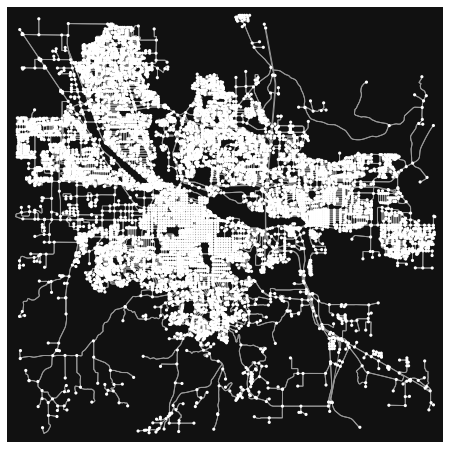

In [21]:
# Define coordinates of Cascade
lat_lon = [44.0463, -123.0737]

# Import walkable street network data around Condon Hall
g = ox.graph_from_point(lat_lon, dist=10000, network_type='drive')

# Plot map
fig, ax = ox.plot_graph(g, node_size=10)

In [22]:
# Convert to graph
graph_proj = ox.project_graph(g)

# Get edges and nodes separately
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [23]:
# Check projection is UTM Zone 10N
print("Coordinate system:", edges_proj.crs)

# Convert the cafe dataset back to UTM Zone 10N
nearest_vets = nearest_vets.to_crs('EPSG:32610')

Coordinate system: +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


In [24]:
# Get x and y coordinates of Cascade
orig_xy = (cascade['centroid'].y.values[0], cascade['centroid'].x.values[0])

# Get x and y coordinates of one of the cafes (the closest of the ten)
target_xy = (nearest_vets['centroid'].y.values[1], nearest_vets['centroid'].x.values[1])

In [25]:
# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node = ox.distance.nearest_nodes(G=graph_proj, X=orig_xy[1], Y=orig_xy[0], return_dist=False)

# Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)

In [26]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')

In [27]:
# Plot the shortest path using folium
m = ox.plot_route_folium(g, route, weight=5)
m

***
This map shows the shortest route for driving to the second farthest veterinary clinic from Cascade Hall. The final destination for the route is ever so slightly off (the destination is actually on E Amazon Protected Bikeway instead of W Amazon Dr.), so that is something to note.

## Question 3 (10 points): 


* a) Calculate the average difference between the Euclidean and network distances for you amenities 


* b) Describe some situations where it would not be advisable to use Euclidean distances?

In [28]:
# Get x and y coordinates of all ten of the nearest cafes
target_xy = (nearest_vets['centroid'].y.values, nearest_vets['centroid'].x.values)

In [29]:
routes = []
distances = []
for i in range(len(target_xy[0])):
    
    # Find the node in the graph that is closest to the target point (here, we want to get the node id)
    target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1][i], Y=target_xy[0][i], return_dist=False)
    
    # Calculate the shortest path
    route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')
    
    # Append route to list
    routes.append(route)
    
    # Get the nodes along the shortest path
    route_nodes = nodes_proj.loc[route]
    
    # Create a geometry for the shortest path
    route_line = LineString(list(route_nodes['geometry'].values))

    # Create a GeoDataFrame
    route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

    # Print length of route
    print('Driving distance to %s = %.1f km' % (nearest_vets['name'].iloc[i], route_geom['geometry'].length / 1000))
    
    # Append distances to list
    distances.append(route_geom['geometry'].length[0])

Driving distance to Bush Animal Hospital = 3.3 km
Driving distance to Bare Bones Dog Wash = 3.8 km
Driving distance to Community Veterinary Center = 6.3 km
Driving distance to Santa Clara Animal Hospital = 8.7 km
Driving distance to Echo Hollow Veterinary Hospital and Urgent Care = 9.9 km
Driving distance to Riverbrook Animal & Eye Clinic = 10.6 km
Driving distance to The Ark Veterinary = 11.0 km


In [30]:
nearest_vets['network_distance'] = distances
nearest_vets

,name,euclidean_distance,centroid,network_distance
1,Bush Animal Hospital,2169.269974,POINT (494171.350 4879188.363),3296.055644
6,Bare Bones Dog Wash,2928.469571,POINT (493552.640 4874143.079),3796.869462
3,Community Veterinary Center,5778.024701,POINT (488783.338 4879287.685),6271.183805
2,Santa Clara Animal Hospital,7561.370891,POINT (489550.003 4883061.102),8725.346488
4,Echo Hollow Veterinary Hospital and Urgent Care,8791.649002,POINT (486384.913 4881239.664),9861.772155
0,Riverbrook Animal & Eye Clinic,9320.960593,POINT (488980.630 4884810.954),10592.788085
5,The Ark Veterinary,9878.888029,POINT (485219.796 4881352.942),11004.201362


In [31]:
avg_dif = (nearest_vets['network_distance'] - nearest_vets['euclidean_distance']).mean()
print("The average difference between the Euclidean and network distances is ", avg_dif, " km.")

The average difference between the Euclidean and network distances is  1017.0834630465188  km.


***
It would be advisable to not use the Euclidean distance when it would otherwise be impossible to keep to the Euclidean route (such as in a city). This is because the Euclidean distance is more or less the point-to-point distance, not counting anything in the way (i.e. buildings). Thus, in cities, it would be more advisable to use a non-Euclidean route, which would likely account for buildings.